In [1]:
import pathlib
from datetime import datetime
from typing import Optional

import numpy as np
import xarray as xr
import keras
from matplotlib import pyplot as plt

from qrennd import get_model, Config, Layout
from qrennd.layouts.plotter import plot

2023-01-05 13:47:53.688153: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
%load_ext tensorboard

In [3]:
def get_syndromes(anc_meas: xr.DataArray) -> xr.DataArray:
    syndromes = anc_meas ^ anc_meas.shift(qec_round=1, fill_value=0)
    syndromes.name = "syndromes"
    return syndromes


def get_defects(
    syndromes: xr.DataArray, frame: Optional[xr.DataArray] = None
) -> xr.DataArray:
    shifted_syn = syndromes.shift(qec_round=1, fill_value=0)

    if frame is not None:
        shifted_syn[dict(qec_round=0)] = frame

    defects = syndromes ^ shifted_syn
    defects.name = "defects"
    return defects


def get_final_defects(
    syndromes: xr.DataArray,
    proj_syndrome: xr.DataArray,
) -> xr.DataArray:
    last_syndrome = syndromes.isel(qec_round=-1)
    proj_anc = proj_syndrome.anc_qubit

    final_defects = last_syndrome.sel(anc_qubit=proj_anc) ^ proj_syndrome
    final_defects.name = "final_defects"
    return final_defects


def preprocess_data(dataset, proj_mat):
    syndromes = get_syndromes(dataset.anc_meas)
    defects = get_defects(syndromes)

    proj_syndrome = (dataset.data_meas @ proj_mat) % 2
    final_defects = get_final_defects(syndromes, proj_syndrome)

    init_states = dataset.init_state.sum(dim="data_qubit") % 2
    log_states = dataset.data_meas.sum(dim="data_qubit") % 2

    labels = log_states.astype(int) ^ init_states

    #inputs = dict(defects=defects.data, final_defects=final_defects.data)
    inputs = dict(defects=syndromes.data, final_defects=dataset.data_meas.data)
    #inputs = dict(defects=dataset.anc_meas.data, final_defects=dataset.data_meas.data)
    outputs = labels.data

    return inputs, outputs

# Load the datasets

In [4]:
NOTEBOOK_DIR = pathlib.Path.cwd() # define the path where the notebook is placed.

LAYOUT_DIR = NOTEBOOK_DIR / "layouts"
if not LAYOUT_DIR.exists():
    raise ValueError("Layout directory does not exist.")

CONFIG_DIR = NOTEBOOK_DIR / "configs"
if not CONFIG_DIR.exists():
    raise ValueError("Config directory does not exist.")

# The train/dev/test data directories are located in the local data directory
DATA_DIR = NOTEBOOK_DIR / "data"
if not DATA_DIR.exists():
    raise ValueError("Train data directory does not exist.")

cur_datetime = datetime.now()
datetime_str = cur_datetime.strftime("%Y%m%d-%H%M%S")

LOG_DIR = NOTEBOOK_DIR / f"logs/{datetime_str}"
LOG_DIR.mkdir(parents=True, exist_ok=True)

CHECKPOINT_DIR = NOTEBOOK_DIR / "tmp/checkpoint"
CHECKPOINT_DIR.mkdir(parents=True, exist_ok=True)

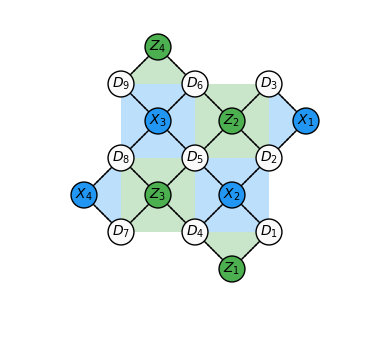

In [5]:
LAYOUT_FILE = "d3_layout.yaml"
layout = Layout.from_yaml(LAYOUT_DIR / LAYOUT_FILE)

fig, ax = plt.subplots(figsize=(4, 4))
plot(layout, label_qubits=True, draw_patches=True, axis=ax)
plt.tight_layout()
plt.show()

In [37]:
data_q = layout.get_qubits(role="data")
anc_q = layout.get_qubits(role="anc", stab_type="z_type")
subgraph = layout.graph.subgraph(nodes = data_q + anc_q)

In [38]:
layout.get_neighbors()

['Z1', 'Z2', 'Z3', 'Z4']

In [53]:
qubits = layout.get_qubits()

qubits.index("D1")

0

In [42]:
list(layout.graph.edges(anc_q, data="north_east"))

[('Z1', 'D1', None),
 ('Z1', 'D4', None),
 ('Z2', 'D2', None),
 ('Z2', 'D3', None),
 ('Z2', 'D5', None),
 ('Z2', 'D6', None),
 ('Z3', 'D4', None),
 ('Z3', 'D5', None),
 ('Z3', 'D7', None),
 ('Z3', 'D8', None),
 ('Z4', 'D6', None),
 ('Z4', 'D9', None)]

In [25]:
layout.graph.edges(data="north_west")

OutEdgeDataView([('D1', 'Z1', None), ('D1', 'X2', None), ('D2', 'X1', None), ('D2', 'X2', None), ('D2', 'Z2', None), ('D3', 'X1', None), ('D3', 'Z2', None), ('D4', 'Z1', None), ('D4', 'X2', None), ('D4', 'Z3', None), ('D5', 'X2', None), ('D5', 'Z2', None), ('D5', 'Z3', None), ('D5', 'X3', None), ('D6', 'Z2', None), ('D6', 'X3', None), ('D6', 'Z4', None), ('D7', 'Z3', None), ('D7', 'X4', None), ('D8', 'Z3', None), ('D8', 'X3', None), ('D8', 'X4', None), ('D9', 'X3', None), ('D9', 'Z4', None), ('X1', 'D2', None), ('X1', 'D3', None), ('X2', 'D1', None), ('X2', 'D2', None), ('X2', 'D4', None), ('X2', 'D5', None), ('X3', 'D5', None), ('X3', 'D6', None), ('X3', 'D8', None), ('X3', 'D9', None), ('X4', 'D7', None), ('X4', 'D8', None), ('Z1', 'D1', None), ('Z1', 'D4', None), ('Z2', 'D2', None), ('Z2', 'D3', None), ('Z2', 'D5', None), ('Z2', 'D6', None), ('Z3', 'D4', None), ('Z3', 'D5', None), ('Z3', 'D7', None), ('Z3', 'D8', None), ('Z4', 'D6', None), ('Z4', 'D9', None)])

In [6]:
CONFIG_FILE = "base_config.yaml"
config = Config.from_yaml(CONFIG_DIR / CONFIG_FILE)

In [7]:
proj_mat = layout.projection_matrix(stab_type="z_type")

train_dataset = xr.load_dataset(
    DATA_DIR / "train/d3_surf_code_seq_round_state_0_shots_1000000_rounds_40.nc"
)
train_input, train_output = preprocess_data(train_dataset, proj_mat)

dev_dataset = xr.load_dataset(
    DATA_DIR / "dev/d3_surf_code_seq_round_state_0_shots_20000_rounds_40.nc"
)
dev_input, dev_output = preprocess_data(dev_dataset, proj_mat)

/Users/boris/Projects/decoders/qrennd/qrennd/layouts/layout.py:145: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj_matrix = nx.adjacency_matrix(self.graph)


In [8]:
main_metrics = [
    keras.metrics.BinaryAccuracy(name="acc"),
    keras.metrics.AUC(num_thresholds=100, name="AUC", curve="ROC")
]

aux_metrics = [
    keras.metrics.BinaryAccuracy(name="acc"),
]

2023-01-05 13:48:03.572169: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [9]:
num_rounds = train_dataset.qec_round.size
num_anc = train_dataset.anc_qubit.size

model = get_model(
    defects_shape=(None, num_anc),
    final_defects_shape=(9, ),
    config=config,
    metrics=dict(
        main_output = main_metrics,
        aux_output = aux_metrics
    )
)

In [10]:
model.summary()

Model: "decoder_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 defects (InputLayer)           [(None, None, 8)]    0           []                               
                                                                                                  
 LSTM_1 (LSTM)                  (None, None, 32)     5248        ['defects[0][0]']                
                                                                                                  
 dropout_LSTM_1 (Dropout)       (None, None, 32)     0           ['LSTM_1[0][0]']                 
                                                                                                  
 LSTM_2 (LSTM)                  (None, 32)           8320        ['dropout_LSTM_1[0][0]']         
                                                                                      

# Training

In [11]:
#  %tensorboard --logdir={LOG_DIR}

In [12]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath=CHECKPOINT_DIR / "weights.hdf5",
        monitor="val_loss",
        mode="min",
        save_best_only=True,
    ),
    keras.callbacks.TensorBoard(log_dir=LOG_DIR, histogram_freq=1),
    keras.callbacks.EarlyStopping(
        monitor="val_loss", mode="min", min_delta=0, patience=3
    ),
]


In [13]:
history = model.fit(
    x=train_input,
    y=train_output,
    validation_data=[dev_input, dev_output],
    batch_size=64,
    epochs=5,
    callbacks=callbacks
)

Epoch 1/5
  416/15625 [..............................] - ETA: 4:07 - loss: 1.0081 - main_output_loss: 0.6726 - aux_output_loss: 0.6700 - main_output_acc: 0.5541 - main_output_AUC: 0.5832 - aux_output_acc: 0.5529

KeyboardInterrupt: 

In [ ]:
test_dataset = xr.load_dataset(
    DATA_DIR / "test/d3_surf_code_seq_round_state_0_shots_20000_rounds_20.nc"
)
test_input, test_output = preprocess_data(test_dataset, proj_mat)

In [ ]:
eval_output = model.evaluate(x=test_input, y=test_output, batch_size=64)

In [ ]:
test_dataset = xr.load_dataset(
    DATA_DIR / "test/d3_surf_code_seq_round_state_0_shots_20000_rounds_20_v2.nc"
)
test_input, test_output = preprocess_data(test_dataset, proj_mat)

In [ ]:
eval_output = model.evaluate(x=test_input, y=test_output, batch_size=64)